### Final Project: Wetland Restoration Suitability Map

This project aims to use cost surface analysis to identify high quality areas for wetland restoration projects. High quality wetland restoration areas are defined as places with hydrologic connection and proximity to existing wetland areas.

The randomized weighting cost surfaces can be found in the "RandomWeighting100" notebook.

____

### Part 1: API Requests and File Extraction/Transformation

#### 0. Import Libraries and Establish Common Terms

In [7]:
# Import Libraries
import io
import os
import sys
import arcpy
import laspy
from zipfile import ZipFile
import zipfile
import pandas as pd
import requests
import ftplib
from bs4 import BeautifulSoup as bs
from arcgis.features import GeoAccessor, GeoSeriesAccessor, FeatureCollection, FeatureSet
from arcpy import env
from arcpy.sa import *

In [2]:
# Common Terms for all layers

# Boundary Extent (not watershed boundary)
# Top	4,887,308.789800	m
# Bottom	4,868,689.051000	m
# Left	379,749.855800	m
# Right	399,383.588100	m

### 1. National Wetland Inventory Data
Use wetland polygon data to identify existing wetland areas and determine proximity (500m or less) and hydrological connectivity.

#### 1a. NWI API Extraction
Request the national wetlands inventory (NWI) geodatabase zipped file. Download the zipped file and then unzip the folder and then extract the files to a local folder.

In [23]:
# Extract NWI Data

# Define the URL and the output path for the ZIP file (MN State Wetlands NWI)
url = r"https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/water_nat_wetlands_inv_2009_2014/fgdb_water_nat_wetlands_inv_2009_2014.zip"
zip_MN_NWI_path = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\ZippedFiles\NWI_MN.zip"

# Create the folder if it doesn't exist
os.makedirs(os.path.dirname(zip_MN_NWI_path), exist_ok=True)

# Download the file using requests.get(), stream=True for chunked downloading
response = requests.get(url, stream=True)

# Get the file size from headers (optional, for progress indication)
file_size = int(response.headers.get('content-length', 0))
print(f"Downloading NWI MN ZIP file ({file_size / 1024 / 1024:.2f} MB)...")

# Stream the download and show a progress bar
with open(zip_MN_NWI_path, 'wb') as f:
    with tqdm(total=file_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:  # Filter out keep-alive new chunks
                f.write(chunk)
                pbar.update(len(chunk))

# Open the ZIP file and print its contents
with zipfile.ZipFile(zip_MN_NWI_path, 'r') as zip_ref:
    # Print the contents of the ZIP file
    zip_ref.printdir()

    # Create a directory for extraction if it doesn't exist
    extraction_path = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Extracted\NWI_MN"
    os.makedirs(extraction_path, exist_ok=True)

    # Extract all files to the specified directory
    zip_ref.extractall(extraction_path)

# Show the files you just extracted
print("Files in the extracted directory:")
print(os.listdir(extraction_path))

Downloading: 100%|██████████| 1.61G/1.61G [00:56<00:00, 28.7MB/s]﻿


File Name                                             Modified             Size
NWI Cowardin Classification.lyr                2019-06-07 13:45:14        22016
NWI USFWS Circular 39 Classification.lyr       2019-06-07 13:45:46        20992
NWI Simplified HGM Classification.lyr          2019-06-07 13:45:22        18432
NWI Simplified Plant Community Classification.lyr 2019-06-07 13:45:36        28160
metadata/metadata.html                         2024-03-28 16:42:04        41011
metadata/metadata.xml                          2024-03-28 16:41:56        38116
water_nat_wetlands_inv_2009-2014.gdb/a00000038.gdbtable 2019-06-20 17:04:42          594
water_nat_wetlands_inv_2009-2014.gdb/a00000037.gdbtable.cdf 2019-06-20 17:04:42         2975
water_nat_wetlands_inv_2009-2014.gdb/a00000039.gdbtable.cdf 2019-06-20 17:04:42       310343
water_nat_wetlands_inv_2009-2014.gdb/a00000004.gdbtable 2019-06-20 17:36:24        32773
water_nat_wetlands_inv_2009-2014.gdb/a00000006.gdbindexes 2015-04-01 21:2

#### 1b. Identify Wetland Buffer Area
Clip the NWI layer to the project boundary and then create a 500 meter buffer to establish hydrologically connected land areas to existing wetlands.

In [ ]:
# Clip the NWI Polygon Layer to Bounding Box

with arcpy.EnvManager(outputCoordinateSystem='PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]', extent='379749.142119867 4868680.82921966 399399.139624079 4887310.82685342 PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]'):
    arcpy.gapro.ClipLayer(
        input_layer="statewide_NWI",
        clip_layer="project_boundary",
        out_feature_class=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\NWI_Clip"
    )
    

# Buffer the NWI Clip File, 500m

arcpy.analysis.PairwiseBuffer(
    in_features="NWI_Clip",
    out_feature_class=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\NWI_Buffer500m",
    buffer_distance_or_field="500 Meters",
    dissolve_option="ALL",
    dissolve_field=None,
    method="GEODESIC",
    max_deviation="0 Meters"
)

#### 1c. Make a Raster Layer with a Mask
Use the raster buffer with a raster field with the max boundary extent to create a field of 0s and the buffer with a value of 1.

In [71]:
import arcpy

# Path to your input layer
input_layer = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\NCLD_polygon.shp"

# Path to save the bounding box
output_bbox = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\BoundingBox"

# Get the extent of the input layer
desc = arcpy.Describe(input_layer)
extent = desc.extent

# Create a bounding box polygon
arcpy.management.CreateFeatureclass(
    out_path=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb",
    out_name="BoundingBox",
    geometry_type="POLYGON",
    spatial_reference=desc.spatialReference
)

# Insert the bounding box into the new feature class
with arcpy.da.InsertCursor(output_bbox, ["SHAPE@"]) as cursor:
    array = arcpy.Array([
        arcpy.Point(extent.XMin, extent.YMin),
        arcpy.Point(extent.XMin, extent.YMax),
        arcpy.Point(extent.XMax, extent.YMax),
        arcpy.Point(extent.XMax, extent.YMin),
        arcpy.Point(extent.XMin, extent.YMin)  # Close the polygon
    ])
    polygon = arcpy.Polygon(array, desc.spatialReference)
    cursor.insertRow([polygon])

print(f"Bounding box created at {output_bbox}")

Bounding box created at C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\BoundingBox


In [19]:
# Create and ID field for the bounding box and buffer layers.

# Paths to your layers
layer1 = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\NWI_Buffer500m"
layer2 = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\BoundingBox"
clipped_nwi = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\NWI_Buffer_Clipped"
erase_box = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\BoundingBox_PairwiseErase"
NWI_merge = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\NWI_Buffer_Merge"

# Field name for the identifier
field_name = "Value"

# Clip the buffer layer to the extent of the bounding box
arcpy.analysis.Clip(layer1, layer2, clipped_nwi)

print(f"Buffer layer clipped to the extent of the bounding box.")

# Function to add and populate the Value field
def add_source_field(layer, field_name, value):
    # Check if the field already exists
    if field_name not in [f.name for f in arcpy.ListFields(layer)]:
        arcpy.management.AddField(layer, field_name, "SHORT")
    # Populate the field with the given value
    arcpy.management.CalculateField(layer, field_name, value, "PYTHON3")

# Add and populate the Value field for each layer
add_source_field(clipped_nwi, field_name, 1)
add_source_field(layer2, field_name, 0)

print(f"Fields created for each layer.")

# Erase buffer features from bounding box
arcpy.analysis.PairwiseErase(
    in_features="BoundingBox",
    erase_features="NWI_Buffer500m",
    out_feature_class=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\BoundingBox_PairwiseErase",
    cluster_tolerance=None
)

# Merge the clipped buffer layer and the bounding box layer
arcpy.management.Merge([clipped_nwi, erase_box], NWI_merge)


print(f"Spatial join completed!")

Buffer layer clipped to the extent of the bounding box.
Fields created for each layer.
Spatial join completed!


#### 1d. Rasterize the polygon buffer area.
Convert the NWI buffer polygons to a rastser for use as a cost surface layer.

In [21]:
# Convert the 500m Buffer Polygon Layer to a Raster

with arcpy.EnvManager(outputCoordinateSystem='PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]'):
    arcpy.conversion.PolygonToRaster(
        in_features=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\NWI_Buffer_Merge",
        value_field="Value",
        out_rasterdataset=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\NWI_Buffer500m_Raster",
        cell_assignment="MAXIMUM_AREA",
        priority_field="NONE",
        cellsize=29.975163816793987,
        build_rat="BUILD"
    )
    
print(f"The buffer layer was successfully rasterized!")

The buffer layer was successfully rasterized!


### 2. National Land Cover Data (NLCD) Data
Use a standardized landcover dataset that contains 16 different classification categories. Reclassify the data into 5 broader groups for easier landuse identification.

Create a 100 m buffer area around the development areas representing areas that are not effectively restored as wetlands.

Create a cost surface that has the categories reclassified as agriculture and vegetation (1), development (-1), and wetland and water (0). Use this surface to identify areas that are most suited for restoration projects (agriculture and vegetation).

#### 2a. NLCD API Extraction
Request the NLCD data for 2021, containing the 16 categorical landcover types.

In [24]:
# Extract NCLD Land Cover Data

# Define the URL and the output path for the ZIP file
url = r"https://s3-us-west-2.amazonaws.com/mrlc/nlcd_2021_land_cover_l48_20230630.zip"
zip_ncld_path = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\ZippedFiles\NCLD_2021.zip"

# Create the folder if it doesn't exist
os.makedirs(os.path.dirname(zip_ncld_path), exist_ok=True)

# Download the file using requests.get(), stream=True for chunked downloading
response = requests.get(url, stream=True)

# Get the file size from headers (optional, for progress indication)
file_size = int(response.headers.get('content-length', 0))
print(f"Downloading NLCD ZIP file ({file_size / 1024 / 1024:.2f} MB)...")

# Stream the download and show a progress bar
with open(zip_ncld_path, 'wb') as f:
    with tqdm(total=file_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:  # Filter out keep-alive new chunks
                f.write(chunk)
                pbar.update(len(chunk))

# Open the ZIP file and print its contents
with zipfile.ZipFile(zip_ncld_path, 'r') as zip_ref:
    # Print the contents of the ZIP file
    zip_ref.printdir()

    # Create a directory for extraction if it doesn't exist
    extraction_path = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Extracted\NLCD_2021"
    os.makedirs(extraction_path, exist_ok=True)

    # Extract all files to the specified directory
    zip_ref.extractall(extraction_path)

# Show the files you just extracted
print("Files in the extracted directory:")
print(os.listdir(extraction_path))

Downloading: 100%|██████████| 1.96G/1.96G [01:06<00:00, 29.3MB/s]﻿


File Name                                             Modified             Size
nlcd_2021_land_cover_l48_20230630.ige          2023-07-10 13:24:40  26350989969
nlcd_2021_land_cover_l48_20230630.img          2023-07-10 15:35:52    435940485
nlcd_2021_land_cover_l48_20230630.xml          2023-07-11 14:56:44        48467
Files in the extracted directory:
['nlcd_2021_land_cover_l48_20230630.ige', 'nlcd_2021_land_cover_l48_20230630.img', 'nlcd_2021_land_cover_l48_20230630.xml']


#### 2b. Identify Developed Lands and Agricultural/Vegetation Lands
Clip the NLCD file to the area boundy and then reclassify the categories into 5 broad cateogries (wetlands, vegetation, agriculture, development, and water) to establish the development areas.

In [41]:
# Clip the NCLD Raster to Bounding Box and Reproject as NAD 83 UTM 15N

with arcpy.EnvManager(outputCoordinateSystem='PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]', snapRaster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\slope_dem", extent='379749.8558 4868689.051 399383.5881 4887308.7898 PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]'):
    arcpy.management.Clip(
        in_raster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Extracted\NLCD_2021\nlcd_2021_land_cover_l48_20230630.img",
        rectangle="379749.8558 4868689.051 399383.5881 4887308.7898",
        out_raster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\NCLD_clipped",
        in_template_dataset="restorable_wetlands.tif",
        nodata_value="255",
        clipping_geometry="NONE",
        maintain_clipping_extent="MAINTAIN_EXTENT"
    )

In [52]:
# Path to your raster
raster_path = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\NCLD_clipped"

# Get raster properties
desc = arcpy.Describe(raster_path)
cell_size = desc.meanCellWidth  # or desc.meanCellHeight
print(f"Original Cell Size: {cell_size}")

Original Cell Size: 29.975163816793987


In [45]:
# Reclassify the NCLD from 16 Categories to 5 Categories

with arcpy.EnvManager(outputCoordinateSystem='PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]', snapRaster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\slope_dem", extent='379749.8558 4868689.051 399383.5881 4887308.7898 PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]'):
        arcpy.ddd.Reclassify(
            in_raster="NCLD_clipped",
            reclass_field="VALUE",
            remap="11 5;21 4;22 4;23 4;24 4;31 4;41 2;42 2;43 2;52 2;71 2;81 3;82 3;90 1;95 1",
            out_raster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\NCLD_reclass",
            missing_values="DATA"
        )

#### 2c. Create 100m buffer for Impervious, Classify as Impervious (0) or Not (1)
Expand cell value for impervious landcover 4 cells from existing impervious areas (cell size ~ 29.9m --> ~100m). Reclassify the impervious areas as 0 (not desireable) and not-impervious (1, 2, 3, and 5) as 1 (desireable).

In [6]:
# Convert input raster to geodatabase format if necessary
input_raster_path = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\ncld_reclass"
gdb_raster_path = r"c:\Users\ethan\documents\ArcGIS\Projects\arc1_finalproject\arc1_finalproject.gdb\ncld_reclass_gdb"

# Check if already exists in GDB format
if not arcpy.Exists(gdb_raster_path):
    arcpy.CopyRaster_management(input_raster_path, gdb_raster_path)
else:
    print("Raster already in geodatabase format.")

In [9]:
# Define input raster path and output path
input_raster = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\ncld_reclass_gdb"
output_path = r"c:\Users\ethan\documents\ArcGIS\Projects\arc1_finalproject\arc1_finalproject.gdb\ncld_imp_expand"

# Apply Expand to increase the area of zones with value 4 by 2 cells
expanded_raster = arcpy.sa.Expand(input_raster, number_cells=4, zone_values=[4])

# Save the result
expanded_raster.save(output_path)

In [11]:
# Reclassify the NLCD values as either impervious (0) or not (1).
arcpy.ddd.Reclassify(
    in_raster="expanded_raster",
    reclass_field="Value",
    remap="1 1;2 1;3 1;4 0;5 1",
    out_raster=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Imperv_Reclass",
    missing_values="DATA"
)

print("NLCD impervious buffer layer has been created.")

NLCD impervious buffer layer has been created.


#### 2d. Identify Agicultural (and Vegetated) Areas
Reclassify a cost surface that highlights agricultural and vegetated lands as most reliable for successful restoration projects.

In [13]:
# Reclassify the NLCD values as agricultural and vegetative (1) or not (0).
arcpy.ddd.Reclassify(
    in_raster=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\ncld_reclass_gdb",
    reclass_field="Value",
    remap="1 0;2 1;3 1;4 0;5 0",
    out_raster=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\AgVeg_Reclass",
    missing_values="DATA"
)

print("NLCD agricultural and vegetative layer has been created.")

NLCD agricultural and vegetative layer has been created.


### 3. DEM Data to Slope and TWI
Use DEM layers from Blue Earth, Brown, and Watonwan counties. Clip the counties to the extent and then create a mosaic data layer. Derive the slope layer and a TWI layer.

#### 3a. DEM API Extraction
Request DEM layers for Blue Earth, Brown, and Watonwan counties.

In [25]:
# Extract DEM Data for Blue Earth, Watonwan, and Brown Counties

# Define the base URL and the counties to check
DOMAIN = "https://resources.gisdata.mn.gov"
BASE_URL = f"{DOMAIN}/pub/data/elevation/lidar/county"
counties = ["blueearth", "brown", "watonwan"]

# Directory where the files will be saved
save_folder = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\ZippedFiles\MN_County_DEM"
os.makedirs(save_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Loop through counties to download and extract the file
for county in counties:
    file_url = f"{BASE_URL}/{county}/elevation_data.gdb.zip"
    file_path = os.path.join(save_folder, f"{county}_elevation_data.gdb.zip")
    
    # Check if the file exists on the server
    response = requests.head(file_url)
    if response.status_code == 200:
        print(f"Found file for {county} county: Downloading...")

        # Download the file with progress bar
        response = requests.get(file_url, stream=True)
        file_size = int(response.headers.get('content-length', 0))
        
        with open(file_path, 'wb') as f, tqdm(total=file_size, unit='B', unit_scale=True, desc=f"Downloading {county}") as pbar:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))

        print(f"Downloaded {file_path}")

        # Extract the ZIP file
        extraction_path = os.path.join(save_folder, f"{county}_extracted")
        os.makedirs(extraction_path, exist_ok=True)
        
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_path)
        
        print(f"Extracted files to {extraction_path}")

    else:
        print(f"No file found for {county} county.")

Found file for blueearth county: Downloading...


Downloaded C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\ZippedFiles\MN_County_DEM\blueearth_elevation_data.gdb.zip
Extracted files to C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\ZippedFiles\MN_County_DEM\blueearth_extracted
Found file for brown county: Downloading...


Downloaded C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\ZippedFiles\MN_County_DEM\brown_elevation_data.gdb.zip
Extracted files to C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\ZippedFiles\MN_County_DEM\brown_extracted
Found file for watonwan county: Downloading...


Downloaded C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\ZippedFiles\MN_County_DEM\watonwan_elevation_data.gdb.zip
Extracted files to C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\ZippedFiles\MN_County_DEM\watonwan_extracted


In [30]:
# Add County DEM Rasters to Mosaic Database and clip to Bounding Box Extent

with arcpy.EnvManager(extent='379749.8558 4868689.051 399383.5881 4887308.7898 PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]'):
    arcpy.management.MosaicToNewRaster(
        input_rasters=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Extracted\blueearth_extracted\elevation_data.gdb\dem_3m_m;C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Extracted\brown_extracted\elevation_data.gdb\dem_3m_m;C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Extracted\watonwan_extracted\elevation_data.gdb\dem_3m_m",
        output_location=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped",
        raster_dataset_name_with_extension="Mosaic_DEM",
        coordinate_system_for_the_raster='PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]',
        pixel_type="8_BIT_UNSIGNED",
        cellsize=None,
        number_of_bands=1,
        mosaic_method="LAST",
        mosaic_colormap_mode="FIRST"
    )

#### 3b. Create Slope Raster
Use the DEM raster mosaic layer to create a slope layer.

In [31]:
# Derive Slope from the DEM raster mosaic layer

with arcpy.EnvManager(r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped"):
    out_raster = arcpy.sa.Slope(
        in_raster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\Mosaic_DEM",
        output_measurement="DEGREE",
        z_factor=1,
        method="PLANAR",
        z_unit="METER",
        analysis_target_device="GPU_THEN_CPU"
    )
    out_raster.save(r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\slope_DEM")

#### 3c. Create Topographic Wetness Index (TWI) Raster
Use the slope layer and an accumulation area (contributing area).

In [17]:
import arcpy
from arcpy.sa import *

# Set the workspace and environment
arcpy.env.workspace = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb"
arcpy.env.overwriteOutput = True

# Define input DEM and output file paths
dem = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\mosaic_dem"
twi_output = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\DEM_TWI"

# Step 1: Calculate the Flow Accumulation
flow_accumulation = FlowAccumulation(dem)

# Step 2: Calculate the Slope in radians, adding a small buffer to avoid division by zero
slope_degrees = Slope(dem, output_measurement="DEGREE")
slope_radians = slope_degrees * (3.14159 / 180) + 0.001  # Adding 0.001 to avoid issues with zero slope

# Step 3: Calculate the upslope contributing area by multiplying flow accumulation by cell size
cell_size = float(arcpy.GetRasterProperties_management(dem, "CELLSIZEX").getOutput(0))  # Assumes square cells
contributing_area = flow_accumulation * cell_size

# Step 4: Calculate TWI using the formula TWI = ln(a / tan(beta))
twi = Ln(Con(contributing_area > 0, contributing_area / Tan(slope_radians)))  # Using Con to handle areas with zero flow

# Step 5: Save the TWI output
twi.save(twi_output)

print("TWI calculation complete.")

TWI calculation complete.


In [22]:
import arcpy

# Define the input TWI raster and output file path
twi_raster = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\DEM_TWI"
output_twi_tif = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\DEM_TWI.tif"

# Use CopyRaster to export the TWI raster to a .tif file
arcpy.CopyRaster_management(twi_raster, output_twi_tif, format="TIFF")

print("TWI raster exported successfully.")

TWI raster exported successfully.


In [23]:
arcpy.ImportToolbox(r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.atbx")
arcpy.archydropro.calculatetopographicwetnessindexsurfaceparameters(
    Input_Smoothed_DEM=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\mosaic_dem",
    Hydrocondition_Method="Continuous Flow",
    Slope_Neighborhood_Distance=10,
    Output_TWI_Raster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\TWI_dem10m",
    Save_Intermediate_Rasters=True,
    Output_TWI_Slope_Raster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\SLP_twi_10m.tif",
    Output_TWI_FAC_Raster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\FAC_CF.tif",
    Input_TWI_Slope=None,
    Input_TWI_FAC_Raster=None
)

AttributeError: module 'arcpy' has no attribute 'archydropro'

#### 3d. Create Layers for Specific Slope and TWI Values

Use the DEM derived slope and TWI rasters to create new cost layers: 1) slope <= 7* and 2) TWI >=7.

In [24]:
# Create a Slope Cost Layer (degrees <= 5).

# Reclassify the Categories by Slope (0-5* = 1, <=10 = 2, <=Max = 3)
with arcpy.EnvManager(outputCoordinateSystem='PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]'):
    arcpy.ddd.Reclassify(
        in_raster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\slope_dem",
        reclass_field="VALUE",
        remap="0 5 1;5 10 0;10 66.788101 0",
        out_raster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\Slope_Reclass",
        missing_values="DATA"
    )

print("Slope reclassification was successfully calculated.")

Slope reclassification was successfully calculated.


In [27]:
# Create a TWI Cost Layer (TWI >= 10)
# Reclassify the Categories by TWI (TWI 0-5 = 1, TWI <=10 = 2, <=20 = 3, >20 = 4)

# Set environment output coordinate system (if required)
arcpy.env.outputCoordinateSystem = arcpy.SpatialReference('NAD 1983 UTM Zone 15N')

# Define paths
input_twi_raster = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\twi_dem10m"
int_twi_raster = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\twi_dem10m_Int"
output_reclass = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\TWI_reclass"

# Step 1: Convert the input TWI raster to integer if it’s in floating-point
int_twi = Int(input_twi_raster)
int_twi.save(int_twi_raster)

# Step 2: Reclassify the integer TWI raster
reclassified_twi = Reclassify(
    in_raster=int_twi_raster,
    reclass_field="VALUE",
    remap=RemapRange([[0.903, 7, 0], [7, 24.65, 1]]),
    missing_values="DATA"
)

# Step 3: Save the output raster
reclassified_twi.save(output_reclass)

print("TWI reclassification was successfully calculated.")

TWI reclassification was successfully calculated.


### 4. Identify Hydric Soils
Hydric soils are soils with characteristics indicative of water saturation for long periods of time, indicating previous wetland probability. Soils identified with greater than 50 percent hydric soil samples were likely to have had wetlands, and are likely to be able to sustain wetland restorations more successfully.

#### 4a. Soils Data API Extraction
Request the soils data using the ArcGIS online Rest API image server.

In [26]:
# Extract Soils Data for Bounding Box
   
# Define the URL and the output path for the ZIP file
url = r"https://websoilsurvey.sc.egov.usda.gov/DSD/Download/AOI/vnuor1iisg3slwbdgugqbp0w/wss_aoi_2024-11-01_09-54-19.zip"
zip_soils_path = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\ZippedFiles\MN_Soils.zip"

# Create the folder if it doesn't exist
os.makedirs(os.path.dirname(zip_ncld_path), exist_ok=True)

# Download the file using requests.get(), stream=True for chunked downloading
response = requests.get(url, stream=True)

# Get the file size from headers (optional, for progress indication)
file_size = int(response.headers.get('content-length', 0))
print(f"Downloading MN Soils Data file ({file_size / 1024 / 1024:.2f} MB)...")

# Stream the download and show a progress bar
with open(zip_soils_path, 'wb') as f:
    with tqdm(total=file_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:  # Filter out keep-alive new chunks
                f.write(chunk)
                pbar.update(len(chunk))

# Open the ZIP file and print its contents
with zipfile.ZipFile(zip_soils_path, 'r') as zip_ref:
    # Print the contents of the ZIP file
    zip_ref.printdir()

    # Create a directory for extraction if it doesn't exist
    extraction_path = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Extracted\MN_Soils"
    os.makedirs(extraction_path, exist_ok=True)

    # Extract all files to the specified directory
    zip_ref.extractall(extraction_path)

# Show the files you just extracted
print("Files in the extracted directory:")
print(os.listdir(extraction_path))

Downloading: 100%|██████████| 21.0M/21.0M [00:22<00:00, 919kB/s] ﻿


File Name                                             Modified             Size
wss_aoi_2024-11-01_09-54-19/readme.txt         2024-11-01 09:54:54        20733
wss_aoi_2024-11-01_09-54-19/soildb_MN_2003.mdb 2012-09-13 11:24:42     12406784
wss_aoi_2024-11-01_09-54-19/soil_metadata_mn013.txt 2024-11-01 09:54:54        58967
wss_aoi_2024-11-01_09-54-19/soil_metadata_mn013.xml 2024-11-01 09:54:54        56665
wss_aoi_2024-11-01_09-54-19/soil_metadata_mn015.txt 2024-11-01 09:54:54        60929
wss_aoi_2024-11-01_09-54-19/soil_metadata_mn015.xml 2024-11-01 09:54:54        59006
wss_aoi_2024-11-01_09-54-19/soil_metadata_mn165.txt 2024-11-01 09:54:54        57245
wss_aoi_2024-11-01_09-54-19/soil_metadata_mn165.xml 2024-11-01 09:54:54        55131
wss_aoi_2024-11-01_09-54-19/thematic/          2024-11-01 09:54:54            0
wss_aoi_2024-11-01_09-54-19/spatial/aoi_a_aoi.dbf 2024-11-01 09:54:18           92
wss_aoi_2024-11-01_09-54-19/spatial/aoi_a_aoi.prj 2024-11-01 09:54:18          145
wss_

In [56]:
# Extract Soils Data for Bounding Box
# Define the URL for the API request
url = "https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Hydric_Class/ImageServer/exportImage"

# Define the parameters
params = {
    "bbox": "-2.00375070672E7,-1617169.7091000006,2.0037507842788246E7,1.15601202909E7",
    "bboxSR": "4326",  # Spatial reference for the bounding box (NAD83 UTM Zone 15N)
    "size": "1024,1024",  # Output image size (adjust as needed)
    "imageSR": "4326",  # Spatial reference for the image
    "format": "tiff",  # Image format (change to 'png' or 'jpg' if needed)
    "pixelType": "U8",  # Pixel type
    "noData": "",  # Optional: Define NoData value if applicable
    "noDataInterpretation": "esriNoDataMatchAny",
    "interpolation": "RSP_BilinearInterpolation",
    "adjustAspectRatio": "true",
    "f": "image"  # Output format
}

# Send the GET request to the ArcGIS REST API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Save the image as a TIFF file
    output_tif_path = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Extracted\soil_hydric_class.tiff"
    with open(output_tif_path, "wb") as file:
        file.write(response.content)
    print(f"Raster image saved to {output_tif_path}")
else:
    print(f"Error occurred: {response.status_code}")

Raster image saved to C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Extracted\soil_hydric_class.tiff


#### Currently Issues accessing the REST API for layer, downloaded manually

arc_api_link = f"https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Hydric_Class/ImageServer/query?where=1%3D1&outFields=*&f=pjson"

https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Hydric_Class/ImageServer/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&outSR=&returnIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&pixelSize=&rasterQuery=&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnDistinctValues=false&multidimensionalDefinition=&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&resultOffset=&resultRecordCount=&f=pjson

#### 4b. Reproject and Clip the Hydric Soils Data
Conform the data the NAD83 UTM 15N projection and clip it the common extent.

In [29]:
# Reproject the Soils Raster into NAD 83 UTM 15N

arcpy.management.ProjectRaster(
    in_raster="hydric_soils.tif",
    out_raster=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\hydric_soils_Project",
    out_coor_system='PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]',
    resampling_type="NEAREST",
    cell_size="29.9999961896375 30",
    geographic_transform="WGS_1984_(ITRF00)_To_NAD_1983",
    Registration_Point=None,
    in_coor_system='PROJCS["WGS_1984_Web_Mercator_Auxiliary_Sphere",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mercator_Auxiliary_Sphere"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],PARAMETER["Standard_Parallel_1",0.0],PARAMETER["Auxiliary_Sphere_Type",0.0],UNIT["Meter",1.0]]',
    vertical="NO_VERTICAL"
)

<Result 'C:\\Users\\ethan\\Documents\\ArcGIS\\Projects\\Arc1_FinalProject\\Arc1_FinalProject.gdb\\hydric_soils_Project'>

In [32]:
# Clip the Reprojected Soils Raster to the Boundary Extent

with arcpy.EnvManager(outputCoordinateSystem='PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]'):
    arcpy.management.Clip(
        in_raster="hydric_soils_Project",
        rectangle="379749.142119867 4868686.82685342 399384.142119867 4887310.82685342",
        out_raster=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\hydric_soils_Clip",
        in_template_dataset="Mosaic_DEM_twi_SLP_an_10mMax_CF.tif",
        nodata_value="255",
        clipping_geometry="NONE",
        maintain_clipping_extent="NO_MAINTAIN_EXTENT"
    )

#### 4c. Create a Soils Cost Layer
Create a cost layer where hydric soils over 50 percent are the highest value.

In [57]:
# Reclassify Soils Data

arcpy.ddd.Reclassify(
    in_raster="hydric_soils_Clip",
    reclass_field="ClassName",
    remap="'Not Hydric' 0;'Partially Hydric (1 - 25%)' 0;'Partially Hydric (26 - 50%)' 1;'Mostly Hydric (76 - 95%)' 1;'All Hydric' 1",
    out_raster=r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\soils_reclass",
    missing_values="DATA"
)

print("Hydric soil classes have been reclassified.")

Hydric soil classes have been reclassified.


____

### Part 2: Develop a Cost Surface Layer and Identify High Priority Areas

#### 5a. Create a Cost Surface Layer

#### Test 1: Equal Weights, 0 = Restricted, 1 = 10

In [31]:
# Create an Equal Cost Surface where Hydric >= 50%, TWI >= 7, Slope <= 3.5, AgVeg = True, ImpervDist >= 100m, NWIdist <= 500m

# TWI and Slope were given 16% versus 17% for all other layers -- due to the flexibility with these inputs and the need for 100% total
# Zeros were made restricted, while 1 values were given scale of 10.

with arcpy.EnvManager(scratchWorkspace=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb"):
    out_raster = arcpy.sa.WeightedOverlay(
        in_weighted_overlay_table=r"('C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\NWI_Buffer500m_Raster' 17 'Value' (0 Restricted; 1 10; NODATA NODATA); 'C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\soils_reclass' 17 'VALUE' (0 Restricted; 1 10; NODATA NODATA); 'C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\TWI_reclass' 16 'VALUE' (0 Restricted; 1 10; NODATA NODATA); 'C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\Slope_Reclass' 16 'VALUE' (0 Restricted; 1 10; NODATA NODATA); 'C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\AgVeg_Reclass' 17 'Value' (0 Restricted; 1 10; NODATA NODATA); 'C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Imperv_Reclass' 17 'Value' (0 Restricted; 1 10; NODATA NODATA));1 10 1"
    )
    out_raster.save(r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal")

#### Test 2: Equal Weights, 0 = 1, 1 = 10

In [30]:
# Create an Equal Cost Surface where Hydric >= 50%, TWI >= 7, Slope <= 3.5, AgVeg = True, ImpervDist >= 100m, NWIdist <= 500m

# TWI and Slope were given 16% versus 17% for all other layers -- due to the flexibility with these inputs and the need for 100% total
# Zeros were given scale of 1, while 1 values were given scale of 10.

with arcpy.EnvManager(scratchWorkspace=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb"):
    out_raster = arcpy.sa.WeightedOverlay(
        in_weighted_overlay_table=r"('C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\NWI_Buffer500m_Raster' 17 'Value' (0 1; 1 10; NODATA NODATA); 'C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\soils_reclass' 17 'VALUE' (0 1; 1 10; NODATA NODATA); 'C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\TWI_reclass' 16 'VALUE' (0 1; 1 10; NODATA NODATA); 'C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\Slope_Reclass' 16 'VALUE' (0 1; 1 10; NODATA NODATA); 'C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\AgVeg_Reclass' 17 'Value' (0 1; 1 10; NODATA NODATA); 'C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Imperv_Reclass' 17 'Value' (0 1; 1 10; NODATA NODATA));1 10 1"
    )
    out_raster.save(r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal_t2")

#### 5b. Evaluate Cost Surface for High Value Wetlands

Determine wetland areas that are 2 cells or larger.

In [56]:
# ZONAL STATS!!!
# Generalization in Spatial Analys - Lots of good options.
# Identify areas with 2 cells the same touching
with arcpy.EnvManager(outputCoordinateSystem='PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]', scratchWorkspace=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb"):
    out_raster = arcpy.sa.FocalStatistics(
        in_raster="out_raster",
        neighborhood="Rectangle 3 3 CELL",
        statistics_type="MEAN",
        ignore_nodata="DATA",
        percentile_value=90
    )
    out_raster.save(r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\FocalSt_EqWg1")

In [57]:
with arcpy.EnvManager(outputCoordinateSystem='PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]', scratchWorkspace=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb"):
    out_raster = arcpy.sa.FocalStatistics(
        in_raster="out_raster",
        neighborhood="Circle 10 CELL",
        statistics_type="MEAN",
        ignore_nodata="DATA",
        percentile_value=90
    )
    out_raster.save(r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\FocalSt_EqWg2")

#### 5d. Compare Results to MN Restorable Wetlands Shapefile

In [32]:
# Clip the MN Restorable Wetlands file to the boundary area

with arcpy.EnvManager(outputCoordinateSystem='PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]],VERTCS["NAVD_1988",VDATUM["North_American_Vertical_Datum_1988"],PARAMETER["Vertical_Shift",0.0],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]'):
    arcpy.analysis.PairwiseClip(
        in_features="MN_Restorable_Wetlands selection",
        clip_features=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\BoundingBox",
        out_feature_class=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\MN_ReWet_Clip",
        cluster_tolerance=None
    )
    
print("Restorable wetlands clipped to the boundary area.")

Restorable wetlands clipped to the boundary area.


_____

### Part 3: Analyze Wetland Site Priorities

#### 6a. Compare to Randomized Weighting

Raster: C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_0, Chi2: 6.07, P-value: 0.7327
Raster: C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_1, Chi2: 2.85, P-value: 0.9701
Raster: C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_2, Chi2: 4.58, P-value: 0.8690
Raster: C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_3, Chi2: 2.27, P-value: 0.9864
Raster: C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_4, Chi2: 1.99, P-value: 0.9917
Raster: C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_5, Chi2: 0.83, P-value: 0.9997
Raster: C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_6, Chi2: 6.06, P-value: 0.7336
Raster: C:\Users\ethan\Documents\A

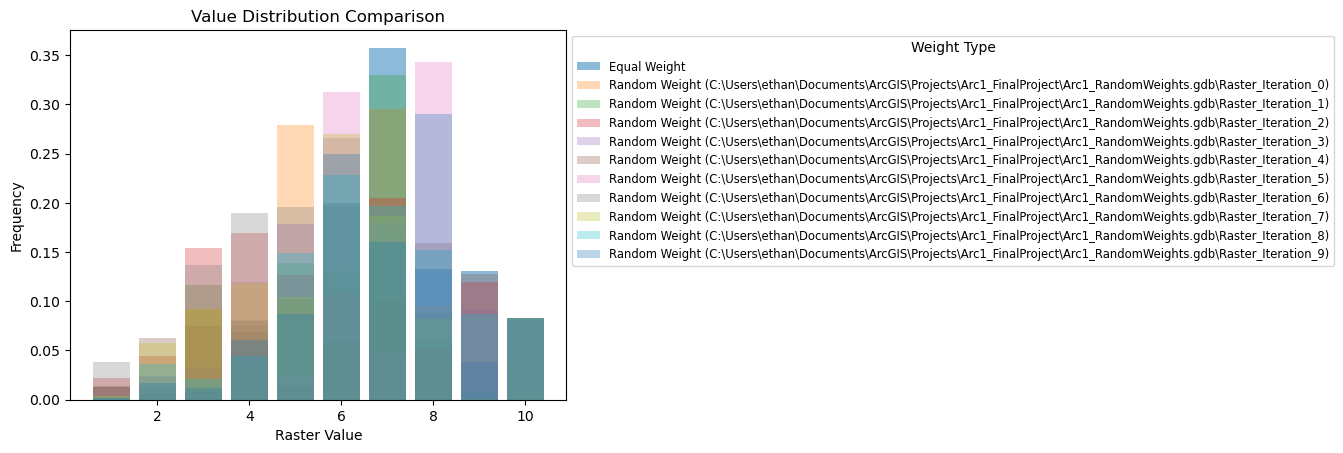

In [17]:
%matplotlib inline
import arcpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare

# Set environment settings
arcpy.env.workspace = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb"
arcpy.env.overwriteOutput = True

# Load the equal-weight raster as a NumPy array
equal_raster = arcpy.RasterToNumPyArray(
    r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal_t2"
)

# List of randomly weighted rasters
random_weight_rasters = [
    r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_0",
    r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_1",
    r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_2",
    r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_3",
    r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_4",
    r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_5",
    r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_6",
    r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_7",
    r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_8",
    r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_RandomWeights.gdb\Raster_Iteration_9",
]

# Define raster value range
value_range = np.arange(1, 12)  # Adjust range to match your raster value range (1–11)

# Get value distribution for the equal-weight raster
equal_hist, _ = np.histogram(equal_raster, bins=value_range, range=(1, 11))

# Normalize the equal-weight histogram
equal_hist = equal_hist / np.sum(equal_hist)

# Plot the equal-weight raster distribution
plt.bar(value_range[:-1], equal_hist, alpha=0.5, label="Equal Weight")

# Placeholder for chi-square test results
chi2_results = []

# Compare with randomly weighted rasters
for raster_path in random_weight_rasters:
    # Load the random-weight raster as a NumPy array
    random_raster = arcpy.RasterToNumPyArray(raster_path)

    # Get value distribution
    random_hist, _ = np.histogram(random_raster, bins=value_range, range=(1, 11))

    # Normalize the random-weight histogram
    random_hist = random_hist / np.sum(random_hist)

    # Perform Chi-square test
    chi2, p_value = chisquare(f_obs=random_hist, f_exp=equal_hist)
    chi2_results.append((raster_path, chi2, p_value))

    print(f"Raster: {raster_path}, Chi2: {chi2:.2f}, P-value: {p_value:.4f}")

    # Plot random raster histogram
    plt.bar(value_range[:-1], random_hist, alpha=0.3, label=f"Random Weight ({raster_path})")

# Customize and display the plot inline
plt.xlabel("Raster Value")
plt.ylabel("Frequency")
plt.title("Value Distribution Comparison")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Weight Type", fontsize="small")
plt.show()

#### 6b. Compare to DNR Results

In [84]:
# Resample the Rasters to Align for Distribution Comparison

import arcpy
from arcpy.sa import *

# Define paths for rasters
equal_raster_path = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal_t2"
dnr_raster_path = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\mn_restorable_wetland_i_Clip1"

# Load the rasters
equal_raster = arcpy.Raster(equal_raster_path)
dnr_raster = arcpy.Raster(dnr_raster_path)

# Define output path for resampled raster
output_resampled_raster = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Resampled_DNR_Raster"

# Perform the resampling (make sure the output is a raster object)
resampled_dnr_raster = arcpy.sa.Resample(dnr_raster, output_resampled_raster, equal_raster.meanCellWidth, "NEAREST")

# Save the result (no need to manually specify the result as the output is handled by Resample)
resampled_dnr_raster.save(output_resampled_raster)

# Print a message to confirm completion
print(f"Resampled DNR raster saved to {output_resampled_raster}")

KeyError: 'C:\\Users\\ethan\\Documents\\ArcGIS\\Projects\\Arc1_FinalProject\\Arc1_FinalProject.gdb\\Resampled_DNR_Raster'

In [79]:
# Find the RMSE values and plot them on a histogram with the R2 Values

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Flatten the arrays for metric calculations
equal_flat = equal_raster_array.flatten()
dnr_flat = dnr_raster_resampled.flatten()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(equal_flat, dnr_flat))
r2 = r2_score(equal_flat, dnr_flat)

# Print summary statistics
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

# Optional: Visualize RMSE and R^2 distributions
plt.figure(figsize=(12, 5))

# RMSE histogram (although we only have one RMSE value, you can visualize it if you loop over more rasters later)
plt.subplot(1, 2, 1)
plt.hist([rmse], bins=20, color='skyblue', edgecolor='black')
plt.title("RMSE Distribution")
plt.xlabel("RMSE")
plt.ylabel("Frequency")

# R^2 histogram
plt.subplot(1, 2, 2)
plt.hist([r2], bins=20, color='salmon', edgecolor='black')
plt.title("R^2 Distribution")
plt.xlabel("R^2")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Equal Raster shape: (621, 655)
DNR Raster shape: (6211, 6551)


#### 6c. Initial Autocorrelation Results

In [ ]:
# Determine the core areas of highest quality wetland restoration land (8,9,10)

# Set environment
arcpy.env.workspace = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb"
arcpy.env.overwriteOutput = True

# Input raster
input_raster = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal_t2"

# Check out the Spatial Analyst extension
arcpy.CheckOutExtension("Spatial")

# Step 1: Reclassify raster to isolate values 8, 9, and 10
reclassified_raster = "Reclassified_WtOv"
remap = arcpy.sa.RemapValue([[8, 1], [9, 1], [10, 1]])  # 1 for best wetlands, 0 for others
reclass = arcpy.sa.Reclassify(input_raster, "VALUE", remap, "NODATA")
reclass.save(reclassified_raster)

# Step 2: Group neighboring cells
region_group_raster = "RegionGroup_WtOv"
region_group = arcpy.sa.RegionGroup(reclassified_raster, "EIGHT", "WITHIN", "ADD_LINK")
region_group.save(region_group_raster)

# Step 3: Filter small regions
# Calculate cell counts for each region using Zonal Statistics
zone_field = "VALUE"
cell_size = arcpy.GetRasterProperties_management(input_raster, "CELLSIZEX")  # Get cell size for area calculation
region_size_raster = "RegionSize_WtOv"
zonal_stats = arcpy.sa.ZonalStatistics(region_group_raster, zone_field, reclassified_raster, "SUM")
zonal_stats.save(region_size_raster)

# Filter regions based on minimum size threshold
min_size_cells = 5  # Minimum number of cells for a region to be retained
filtered_raster = "Filtered_WtOv"
filtered = arcpy.sa.Con(zonal_stats >= min_size_cells, region_group_raster)
filtered.save(filtered_raster)

# Step 4: Convert raster to polygons
output_polygon = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\BestWetlandAreas.shp"
arcpy.RasterToPolygon_conversion(filtered_raster, output_polygon, "NO_SIMPLIFY", "VALUE")

# Step 5: Add area calculation
arcpy.AddGeometryAttributes_management(output_polygon, "AREA", Area_Unit="SQUARE_METERS")

# Optional: Filter polygons by area (example threshold: 100 square meters)
final_polygon = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\FinalWetlandAreas.shp"
area_threshold = 100  # in square meters
arcpy.analysis.Select(output_polygon, final_polygon, f"AREA >= {area_threshold}")

print("Best wetland areas identified and saved as polygons.")

In [13]:
# Calculate Moran's I for BestWetlandAreas

arcpy.env.workspace = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb"

arcpy.stats.SpatialAutocorrelation(
    Input_Feature_Class="BestWetlandAreas",  # Path to your polygon feature class
    Input_Field="gridcode",  # Field to analyze spatial autocorrelation
    Generate_Report=True,  # Boolean value to generate a report
    Conceptualization_of_Spatial_Relationships="INVERSE_DISTANCE_SQUARED",  # Relationship type
    Distance_Method="EUCLIDEAN_DISTANCE",  # How distances are calculated
    Standardization="ROW",  # Standardization method for weights
    Distance_Band_or_Threshold_Distance="",  # Optional, empty for automatic calculation
    Weights_Matrix_File="",  # Optional, not needed for inverse distance
    number_of_neighbors=None  # Removed: not a parameter for this tool
)

print("Moran's I analysis has completed.")

Moran's I analysis has completed.


___

### 7. Subdivide the Watershed for Analysis

#### 7a. Create a Stacked Grid within Watershed Polygon (250 acres)

In [4]:
# Make equal areas around 1km2 (~250 acres, mean acreage in MN ~460 acres)

target_area = "1 Squarekilometers"

arcpy.management.SubdividePolygon(
    in_polygons="WBD HUC 12 selection",
    out_feature_class=r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Wtrshd_Subs",
    method="EQUAL_AREAS",
    num_areas=None,
    target_area=target_area,
    target_width=None,
    split_angle=0,
    subdivision_type="STACKED_BLOCKS"
)

print(f"Subdivision completed with {target_area} units.")

Subdivision completed with 1 Squarekilometers units.


#### 7b. Apply Zonal Statistics for Equal Weight Mean and DNR Model Mean

In [8]:
# Use Zonal Statistics to calculate the mean for each subdivided polygon
raster_layer = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal_t2"
subdivided_polygons = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Wtrshd_Subs"

# Run Zonal Statistics As Table
out_table = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Zonal_EqWt_T2"
arcpy.sa.ZonalStatisticsAsTable(subdivided_polygons, "FID", raster_layer, out_table, statistics_type="MEAN")

print(f"Zonal mean statistics calculated and saved to {out_table}")

Zonal mean statistics calculated and saved to C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Zonal_EqWt_T2


In [12]:
# Add zonal equal weight value to subdivided areas
subdivided_polygons = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Wtrshd_Subs"
out_table = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Zonal_EqWt_T2"

# Add the zonal mean value as a new field in the subdivided polygon layer
field_name = "EqWt_Zonal"
arcpy.AddField_management(subdivided_polygons, field_name, "DOUBLE")

arcpy.management.AddJoin(
    in_layer_or_view="Wtrshd_Subs",
    in_field="OBJECTID",
    join_table="Zonal_EqWt_T2",
    join_field="OBJECTID",
    join_type="KEEP_ALL",
    index_join_fields="NO_INDEX_JOIN_FIELDS",
    rebuild_index="NO_REBUILD_INDEX"
)

print(f"Zonal mean values were added to subdivided polygons in {subdivided_polygons}.")

Zonal mean values were added to subdivided polygons in C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Wtrshd_Subs.


#### Equal Weight Zonal Stats

In [52]:
# Use zonal stats on the Wetland Restorable layer for comparison

raster_layer = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal_t2"
subdivided_polygons = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Wtrshd_Subs"

# Add the zonal mean value as a new field in the subdivided polygon layer
field_name = "Wetland_Zonal"
arcpy.AddField_management(subdivided_polygons, field_name, "DOUBLE")

# Run Zonal Statistics As Table
out_table = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Zonal_Wetland"
arcpy.sa.ZonalStatisticsAsTable(subdivided_polygons, "FID", raster_layer, out_table, statistics_type="MEAN")

print(f"Zonal mean statistics calculated and saved to {out_table}")


Zonal mean statistics calculated and saved to C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Zonal_Wetland


In [53]:
# Add zonal equal weight value to subdivided areas
subdivided_polygons = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Wtrshd_Subs"
out_table = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Zonal_MN_DNR"

# Add the zonal mean value as a new field in the subdivided polygon layer
field_name = "Wetland_Zonal"
arcpy.AddField_management(subdivided_polygons, field_name, "DOUBLE")

arcpy.management.AddJoin(
    in_layer_or_view="Wtrshd_Subs",
    in_field="OBJECTID",
    join_table="Zonal_Wetland",
    join_field="OBJECTID",
    join_type="KEEP_ALL",
    index_join_fields="NO_INDEX_JOIN_FIELDS",
    rebuild_index="NO_REBUILD_INDEX"
)

print(f"Zonal mean values were added to subdivided polygons in {subdivided_polygons}.")

Zonal mean values were added to subdivided polygons in C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Wtrshd_Subs.


#### DNR Model Zonal Stats

In [47]:
# Use zonal stats on the MN DNR Model for comparison

raster_layer = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\mn_restorable_wetland_i_Clip1"
subdivided_polygons = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Wtrshd_Subs"

# Add the zonal mean value as a new field in the subdivided polygon layer
field_name = "DNR_Zonal"
arcpy.AddField_management(subdivided_polygons, field_name, "DOUBLE")

# Run Zonal Statistics As Table
out_table = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Zonal_MN_DNR"
arcpy.sa.ZonalStatisticsAsTable(subdivided_polygons, "FID", raster_layer, out_table, statistics_type="MEAN")

print(f"Zonal mean statistics calculated and saved to {out_table}")


Zonal mean statistics calculated and saved to C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Zonal_MN_DNR


In [48]:
# Add zonal equal weight value to subdivided areas
subdivided_polygons = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Wtrshd_Subs"
out_table = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Zonal_MN_DNR"

# Add the zonal mean value as a new field in the subdivided polygon layer
field_name = "DNR_Zonal"
arcpy.AddField_management(subdivided_polygons, field_name, "DOUBLE")

arcpy.management.AddJoin(
    in_layer_or_view="Wtrshd_Subs",
    in_field="OBJECTID",
    join_table="Zonal_MN_DNR",
    join_field="OBJECTID",
    join_type="KEEP_ALL",
    index_join_fields="NO_INDEX_JOIN_FIELDS",
    rebuild_index="NO_REBUILD_INDEX"
)

print(f"Zonal mean values were added to subdivided polygons in {subdivided_polygons}.")

Zonal mean values were added to subdivided polygons in C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Wtrshd_Subs.


#### 7c. Compare the Zonal Statistics (RMSE, R2)

In [62]:
# Compare the Equal Weight Score and DNR Score

import arcpy
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Path to the subdivided polygons feature class
subdivided_polygons = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Wtrshd_Subs"

# Fields for Equal Weight and DNR scores (replace with actual field names from your table)
fields = ["Wetland_Zonal", "DNR_Zonal"]

# Extract the fields into a numpy array
data_array = arcpy.da.TableToNumPyArray(subdivided_polygons, fields)

# Convert to a pandas DataFrame
df = pd.DataFrame(data_array)

# Drop rows with missing values (important for RMSE/R² calculations)
df = df.dropna()

# Extract values as separate numpy arrays
y_true = df["Wetland_Zonal"].values  # Ground truth (Equal Weight)
y_pred = df["DNR_Zonal"].values      # Predicted values (DNR Score)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Compute R² (Coefficient of Determination)
r2 = r2_score(y_true, y_pred)

# Print Results
print("Root Mean Square Error (RMSE):", rmse)
print("R² (Coefficient of Determination):", r2)

# Optional: Display basic stats for context
print("\nDescriptive Statistics:")
print(df.describe())

Root Mean Square Error (RMSE): 4.610074837094119
R² (Coefficient of Determination): -26.042197295967487

Descriptive Statistics:
       Wetland_Zonal   DNR_Zonal
count     219.000000  219.000000
mean        7.176009    2.642489
std         0.888548    0.361384
min         3.036585    2.101930
25%         6.616361    2.385215
50%         7.187826    2.598541
75%         7.771302    2.813125
max         9.001736    4.091886


In [64]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_true_norm = scaler.fit_transform(y_true.reshape(-1, 1)).flatten()
y_pred_norm = scaler.fit_transform(y_pred.reshape(-1, 1)).flatten()

# Compute normalized RMSE and R²
rmse_norm = np.sqrt(mean_squared_error(y_true_norm, y_pred_norm))
r2_norm = r2_score(y_true_norm, y_pred_norm)

print("Normalized RMSE:", rmse_norm)
print("Normalized R²:", r2_norm)

Normalized RMSE: 0.46374066862340324
Normalized R²: -8.736867050343312


In [67]:
import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred, c="blue", label="Data Points")
plt.plot(y_true, y_true, color="red", linestyle="--", label="1:1 Line")
plt.xlabel("Wetland Zonal (Equal Weight)")
plt.ylabel("DNR Zonal")
plt.title("Scatter Plot: Equal Weight vs DNR")
plt.legend()
plt.grid()
plt.show()

#### Attempt to Create Average of 100 Random Layers

In [14]:
# Create an Average Layer for the 100 Random Value Layers
import arcpy
import numpy as np

# Set environment settings
arcpy.env.workspace = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb"
arcpy.env.overwriteOutput = True

# List all rasters in the RandWeights_100.gdb workspace
random_weight_rasters = arcpy.ListRasters()

# Check if there are rasters to process
if len(random_weight_rasters) > 0:
    # Initialize a variable to store the sum of all rasters
    total_array = None
    raster_count = 0
    
    # Convert the first raster to a raster object to access its properties
    first_raster = arcpy.Raster(random_weight_rasters[0])
    
    # Iterate through all the rasters
    for raster in random_weight_rasters:
        # Convert each raster to a NumPy array
        raster_array = arcpy.RasterToNumPyArray(raster)
        
        # If this is the first raster, initialize the total_array
        if total_array is None:
            total_array = raster_array
        else:
            # Add the current raster's array to the total sum
            total_array += raster_array
        
        # Increment the raster count
        raster_count += 1
    
    # Calculate the average by dividing the total sum by the number of rasters
    if raster_count > 0:
        average_array = total_array / raster_count
        
        # Convert the NumPy array back to a raster
        average_raster = arcpy.NumPyArrayToRaster(average_array, 
                                                  first_raster.extent.lowerLeft, 
                                                  first_raster.meanCellWidth, 
                                                  first_raster.meanCellHeight)
        
        # Save the result
        output_raster = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb\Average_Random_Weights"
        average_raster.save(output_raster)
        
        print(f"Average raster saved to {output_raster}")
    else:
        print("No rasters found in the workspace.")
else:
    print("No random weight rasters found.")

Average raster saved to C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb\Average_Random_Weights


___